In [28]:
# imports
import pickle
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import StratifiedKFold, train_test_split
from sympy.stats.rv import probability
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler # To preprocess data for SVM - greatly improves performance
from sklearn.svm import SVC
from pytorch_tabr import TabRClassifier as TabRClassifier_
import lime
import lime.lime_tabular
import shap
from itertools import product
from typing import Tuple, Union, Optional, Callable
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings

In [5]:
def SVMClassifier(**hyperparams):
    return make_pipeline(StandardScaler(), SVC(**hyperparams))

In [56]:
class TabRClassifier(TabRClassifier_):
    def __init__(self, **kwargs):
        # selection_function_name="sparsemax",
        # context_dropout=0.5,
        # context_sample_size=2000,
        # num_embeddings={"type": "PLREmbeddings", "n_frequencies": 32, "frequency_scale": 32, "d_embedding": 32, "lite": False},
        super().__init__(**kwargs)
        self.type_embeddings="one-hot"
        self.device_name="cpu"
        self.optimizer_params={"lr": 2e-4}
        
    def fit(
        self,
        X_train: pd.DataFrame,
        y_train: pd.DataFrame,
        **kwargs
    ) -> None:
        super().fit(X_train=X_train.values, y_train=y_train.values,
                    max_epochs=1, batch_size=25, **kwargs)
        
    def predict(self, X: pd.DataFrame):
        return super().predict(X=X.values)
    
    def predict_proba(self, X: pd.DataFrame):
        return super().predict_proba(X=X.values)
        

In [7]:
# constants
SEED = 42
NUM_SPLITS = 10
INITIAL_CUTOFF = 0.05
TOP = 0.01
TARGET = "decision"
MODELS = [XGBClassifier, SVMClassifier, TabRClassifier]

XGBCLASSIFIER_HYPERPARAMETERS = {
    "max_depth": [3, 4, 6, 8, 10],
    "min_child_weight": [1, 4, 8, 16],
    "eta": [0.1, 0.3, 0.6],
    "subsample": [0.5, 1],
    "lambda": [0, 0.2, 1, 5, 12, 25],
    "alpha": [0, 0.2, 1, 5, 12, 25],
}

SVMCLASSIFIER_HYPERPARAMETERS = {
    "kernel": ['poly', 'rbf', 'sigmoid'],
    'degree': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'C': [0.05, 0.1, 0.25, 0.5, 1, 2, 4, 8, 16, 24, 32, 64],
    'gamma': ['auto', 0.1, 0.25, 0.5, 1, 2, 4, 8, 12]
}

TABRCLASSIFIER_HYPERPARAMETERS = {
   "d_main": [12, 24, 36, 48, 60, 96],
    "d_multiplier": [1.2, 1.5, 1.8, 2],
    "context_dropout":  [0, 0.5],
    "dropout0":  [0, 0.5],
    "dropout1":  ["dropout0"],
    "context_size": [12, 24, 36, 48, 60, 96],
    "encoder_n_blocks": [1, 2],
    "predictor_n_blocks": [1, 2],
    "seed": [SEED]
}

HYPERPARAMETERS = {
    XGBClassifier.__name__ : XGBCLASSIFIER_HYPERPARAMETERS,
    SVMClassifier.__name__ : SVMCLASSIFIER_HYPERPARAMETERS,
    TabRClassifier.__name__ : TABRCLASSIFIER_HYPERPARAMETERS
}

In [8]:
def one_hot_encode(df, features):
    for feature in features:
        dummies = pd.get_dummies(df.loc[:, feature], prefix=feature)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(feature, axis=1)
    return df

In [9]:
# load dataset
dataset = pd.read_csv("SpeedDating.csv", index_col=0)

# remove redundant columns
subset = ['gender', 'age', 'age_o', 'race', 'race_o', 'importance_same_race', 'importance_same_religion',
          'pref_o_attractive', 'pref_o_sincere', 'pref_o_intelligence',
          'pref_o_funny', 'pref_o_ambitious', 'pref_o_shared_interests', 'attractive_o', 'sinsere_o', 'intelligence_o', 'funny_o',
          'ambitous_o', 'shared_interests_o', 'attractive_important', 'sincere_important', 'intellicence_important', 'funny_important', 'ambtition_important',
          'shared_interests_important', 'attractive', 'sincere', 'intelligence', 'funny', 'ambition', 'attractive_partner', 'sincere_partner',
          'intelligence_partner', 'funny_partner', 'ambition_partner', 'shared_interests_partner',
          'sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies', 'concerts',
          'music', 'shopping', 'yoga',
          'interests_correlate', 'expected_happy_with_sd_people', 'expected_num_matches', 'expected_num_interested_in_me',
          'like', 'guess_prob_liked', 'decision']

dataset = dataset.loc[:, subset]
dataset.loc[:, 'gender'] = (dataset.loc[:, 'gender'] == 'female') # one hot encode gender
dataset = one_hot_encode(dataset, ['race', 'race_o'])
dataset = dataset.apply(pd.to_numeric, errors='coerce', axis=1)
dataset = dataset.fillna(dataset.mean())
print(dataset.head())
X, y = dataset.loc[:, dataset.columns != TARGET], dataset.loc[:, TARGET]
BASELINE = np.sum(y == 1) / np.sum(y == 0)


C:\Users\mracz\AppData\Local\Temp\ipykernel_16692\3974884003.py:2: DtypeWarning: Columns (4,11,12,16,17,18,19,20,40,41,42,43,44,45,52,53,54,55,56,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,108,110) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv("SpeedDating.csv", index_col=0)


    gender   age  age_o  importance_same_race  importance_same_religion  \
id                                                                        
1      1.0  21.0   27.0                   2.0                       4.0   
2      1.0  21.0   22.0                   2.0                       4.0   
3      1.0  21.0   22.0                   2.0                       4.0   
4      1.0  21.0   23.0                   2.0                       4.0   
5      1.0  21.0   24.0                   2.0                       4.0   

    pref_o_attractive  pref_o_sincere  pref_o_intelligence  pref_o_funny  \
id                                                                         
1                35.0            20.0                 20.0          20.0   
2                60.0             0.0                  0.0          40.0   
3                19.0            18.0                 19.0          18.0   
4                30.0             5.0                 15.0          40.0   
5                3

In [7]:
def train_test_models(models, hyperparameters, X, y):
    accuracies = {}
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=SEED)
    for model_class in tqdm(models):
        model_hyperparameters = hyperparameters[model_class.__name__]
        accuracies[model_class.__name__] = []
        for hyperparams in tqdm(product(*model_hyperparameters.values())):
            kwargs = dict(zip(model_hyperparameters.keys(), hyperparams))
            if model_class.__name__ == 'SVMClassifier':
                if kwargs['kernel'] != 'poly' and kwargs['degree'] != 3:
                    continue
            model = model_class(**kwargs)
            model.fit(X_train, y_train)
            acc = np.mean(model.predict(X_test) == np.array(y_test))
            accuracies[model_class.__name__].append((acc, kwargs))
    return accuracies

In [8]:
def cross_validate_models(models, kwargs_lists, X, y):
    accuracies = {}
    kf = StratifiedKFold(n_splits=NUM_SPLITS, shuffle=True, random_state=SEED)
    for model_class in tqdm(models):
        accuracies[model_class.__name__] = []
        for kwargs in tqdm(kwargs_lists[model_class.__name__]):
            s=0
            model = model_class(**kwargs)
            for train_idx, test_idx in kf.split(X, y):
                X_train, y_train = X.iloc[train_idx, :], y.iloc[train_idx]
                X_test, y_test = X.iloc[test_idx, :], y.iloc[test_idx]
                model.fit(X_train, y_train)
                s += np.mean(model.predict(X_test) == np.array(y_test))
            accuracies[model_class.__name__].append((s/NUM_SPLITS, kwargs))
    return accuracies

In [9]:
def get_top_kwargs(models, accuracies, cutoff):
    top_kwargs = {}
    for model_class in models:
        _, top_models_ = zip(*(sorted(accuracies[model_class.__name__], key=lambda x: x[0])[-int(cutoff*len(accuracies[model_class.__name__])):]))
        top_kwargs[model_class.__name__] = list(top_models_)
    return top_kwargs

In [10]:
def get_rashomon_sets(models, hyperparameters, X, y, initial_cutoff=0.05, top=0.01):
    assert top <= initial_cutoff
    initial_accuracies = train_test_models(models, hyperparameters, X, y)
    filtered_kwargs_lists = get_top_kwargs(models, initial_accuracies, initial_cutoff)
    final_accuracies = cross_validate_models(models, filtered_kwargs_lists, X, y)
    top_kwargs = get_top_kwargs(models, final_accuracies, top/initial_cutoff)
    return top_kwargs

In [17]:
rashomon_sets_params = get_rashomon_sets(MODELS, HYPERPARAMETERS, X, y, INITIAL_CUTOFF, TOP)
pickle.dump(rashomon_sets_params, open('rashomon_sets_params.pickle', 'wb'))

NameError: name 'INITIAL_CUTOFF' is not defined

In [ ]:
# rashomon_sets_params = pickle.load(open('rashomon_sets_params.pickle', 'rb'))

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=(SEED+1))
rashomon_sets = {}
rashomon_sets_acc_lower_bounds = {}
accuracies = {}
for model_class in MODELS:
    rashomon_sets[model_class.__name__] = []
    accuracies[model_class.__name__] = []
    for kwargs in rashomon_sets_params[model_class.__name__]:
        if model_class.__name__ == 'SVMClassifier':
            model = model_class(probability=True, **kwargs)
        else:
            model = model_class(**kwargs)
        model.fit(X_train, y_train)
        acc = np.mean(model.predict(X_test) == np.array(y_test))
        accuracies[model_class.__name__].append(acc)
        rashomon_sets[model_class.__name__].append(model)
    rashomon_sets_acc_lower_bounds[model_class.__name__] = min(accuracies[model_class.__name__])

NameError: name 'rashomon_sets_params' is not defined

In [ ]:
# Compare accuracies for different Rashomon sets
plt.figure(figsize=(16, 8))
plt.title("Rashomon set accuracy comparison between different model classes")
plt.axhline(BASELINE, color='black', linestyle='--', linewidth=1, label='baseline')
plt.xlabel('model class')
plt.ylabel('accuracy')
plt.boxplot([accuracies[model_class.__name__] for model_class in MODELS])
plt.xticks(np.arange(1, 1+len(MODELS)), [model_class.__name__ for model_class in MODELS])
plt.legend()

In [22]:
INDICES = [42, 123, 314]
RANDOM_SAMPLES = [X_test.iloc[i, :] for i in INDICES]

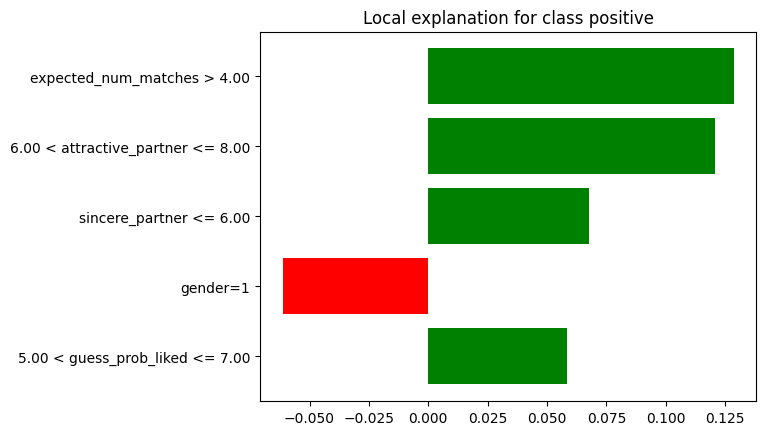

In [32]:
# LIME
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    categorical_features = [0, 3, 4, -1]
    lime_explainer = lime.lime_tabular.LimeTabularExplainer(X.to_numpy(), categorical_features=categorical_features, feature_names=list(X.columns), class_names=['negative', 'positive'])
    for model_class in MODELS:
        for model in rashomon_sets[model_class.__name__]:
            explaination = lime_explainer.explain_instance(X_test.iloc[[SEED], :], model.predict_proba, num_features=5)
            fig = explaination.as_pyplot_figure()
            plt.plot()


In [ ]:
# Shap
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for model_class in MODELS:
        for model in rashomon_sets[model_class.__name__]:
            shap_explainer = shap.KernelExplainer(model.predict, X_train, feature_names=list(X.columns))
            explaination = shap_explainer(X_test.iloc[[SEED], :])
            shap_values = explaination.values    
            shap.plots.beeswarm(explaination)
            plt.plot()
